In [1]:
import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns; sns.set()
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neighbors import KernelDensity

In [2]:
infile = "jktebop_fit1.out"
data = np.loadtxt(infile,unpack=True,dtype=np.float64,usecols=(2,3,4,6,9))
data[3] *= 24*60
index = np.where((data[1]<=0.7) & (data[2]>85.0))
print(len(index[0]))
header = ['R$_B + R_A$',
          '$R_B / R_A$',
          'Inclination',
          'Period',
          'L$_B / L_A$']


8998


In [3]:
def oned_kde(x,k):

# Uncomment to use GridSearchCV to find bandwidth
# Will take 6mins ish per parameter.

#    print(f"Starting 1-D KDE")
#    start = time.time()
#    xmin = np.percentile(x,10)
#    xmax = np.percentile(x,90)
#
#    lband = (xmax-xmin)/1000.
#    hband = (xmax-xmin)/10.
#    print(np.round(lband,5),np.round(hband,5))
#
#    bandwidths = 10 ** np.linspace(-1, 1, 100)
#    bandwidths = np.linspace(lband,hband,100)
#    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                        {'bandwidth': bandwidths},
#                        cv=KFold(n_splits=5))
#    grid.fit(x[:, None])
#    bw = grid.best_params_['bandwidth']
#    print(f"Bandwidth: {bw}")

    bw = [0.002911009, 0.015708919, 0.050280994112,(5e-10)*24*60,0.0005]
    x_d = np.linspace(min(x), max(x), 10000)
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=bw[k], kernel='gaussian')
    kde.fit(x[:,None])
    logprob = kde.score_samples(x_d[:, None])

#    print(f"1-D KDE finished: {np.round(time.time()-start,2)} minutes")

    return(x_d,np.exp(logprob))


In [4]:
def twod_kde(x,y):

    xmin,xmax = min(x), max(x)
    ymin,ymax = min(y), max(y)

    xx,yy = np.mgrid[xmin:xmax:100j,ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    values = np.vstack([x,y])
    kernel = stats.gaussian_kde(values,bw_method='scott')
    f = np.reshape(kernel(positions).T,xx.shape)

    return(xx,yy,f)


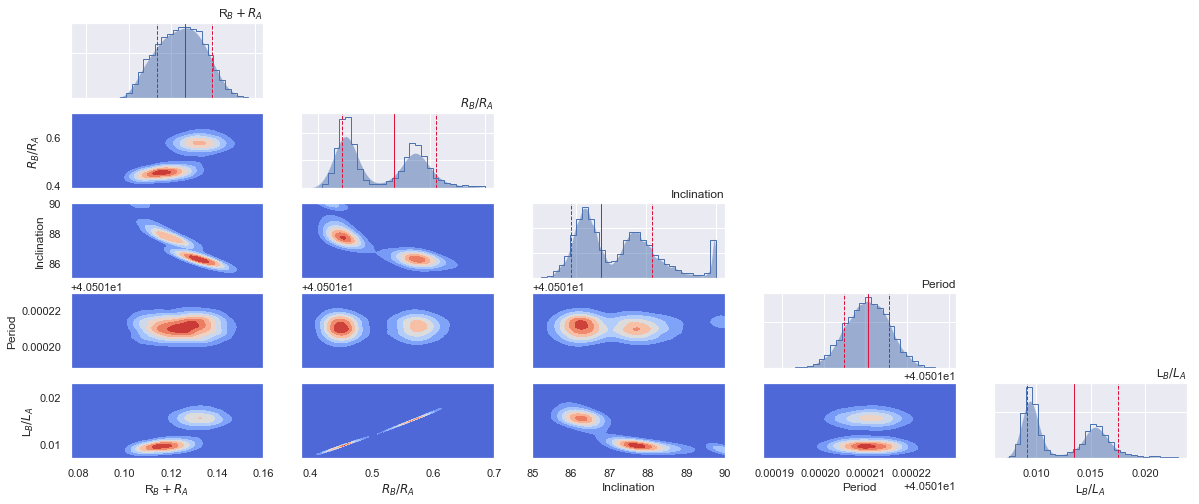

In [11]:
fig,ax = plt.subplots(nrows=5,ncols=5,figsize=(20,8))

for k in range(len(data)):

    x,y = oned_kde(data[k][index],k)


    for j in range(len(data)):
        if j > k:
            fig.delaxes(ax[k,j])
            continue
        else:
            ax[k,j].tick_params(labelbottom=False,labelleft=False)

        if k == j:
            ax[k,j].fill_between(x, y, alpha=0.5)
            ax[k,j].hist(data[k][index],histtype="step",bins=30,density=True)
            ax[k,j].set_title(header[k],loc='right')
            ax[k,j].axvline(x=np.percentile(data[k],50),color="crimson",linewidth=1)
            ax[k,j].axvline(x=np.percentile(data[k],15.87),color="crimson",linestyle="--",linewidth=1)
            ax[k,j].axvline(x=np.percentile(data[k],84.13),color="crimson",linestyle="--",linewidth=1)
        if k == len(data)-1:
            ax[k,j].tick_params(labelbottom=True)
            ax[k,j].set_xlabel(header[j])
        if j == 0:
            if k != 0:
                ax[k,j].tick_params(labelleft=True)
                ax[k,j].set_ylabel(header[k])

        if k != j:
            xx,yy,f = twod_kde(data[j][index],data[k][index])
            ax[k,j].contourf(xx,yy,f,cmap='coolwarm',origin='lower')


In [6]:
from scipy.optimize import curve_fit
from scipy.special import factorial

def double_gauss(x, a1, mu1, sig1, a2, mu2, sig2):
    g = a1*np.exp((-1.0/2.0)*((x-mu1)/sig1)**2.0) + a2*np.exp((-1.0/2.0)*((x-mu2)/sig2)**2.0)
    return(g)

def single_gauss(x, a, mu, sig):
    g = a*np.exp((-1.0/2.0)*((x-mu)/sig)**2.0)
    return(g)

def poisson(x, z):
    p = (z**x)*np.exp(-z)/factorial(x)
    return(p)

def gauss_poisson(x, a, mu, sig, z):
    c = a*np.exp((-1.0/2.0)*((x-mu)/sig)**2.0) + (z**x)*np.exp(-z)/factorial(x)
    return(c)
    

In [7]:
x_d1, y_d1 = oned_kde(data[1],1) # x and y values for the kde distribution.
popt1, pcov1 = curve_fit(double_gauss, x_d1, y_d1, p0=[10.0, 0.452, 0.05, 8.0, 0.578, 0.05])

x_d2, y_d2 = oned_kde(data[2],2) # x and y values for the kde distribution.
popt2, pcov2 = curve_fit(double_gauss, x_d2, y_d2, p0=[0.53, 86.3, 0.3, 0.37, 87.6, 0.4])

x_d3, y_d3 = oned_kde(data[4],4) # x and y values for the kde distribution.
popt3, pcov3 = curve_fit(double_gauss, x_d3, y_d3, p0=[260, 0.009, 0.001, 130, 0.016, 0.003])

In [8]:
for k in range(len(popt3)):
    print(popt3[k],np.sqrt(pcov3[k][k]))

224.38252487268227 0.2506999095093559
0.009482394133916171 1.071980613271264e-06
0.0008308060969897386 1.07300560452771e-06
116.852746249603 0.1970048105209137
0.01549074094511898 2.6193277299575133e-06
0.0013456926562911303 2.6223520806561387e-06


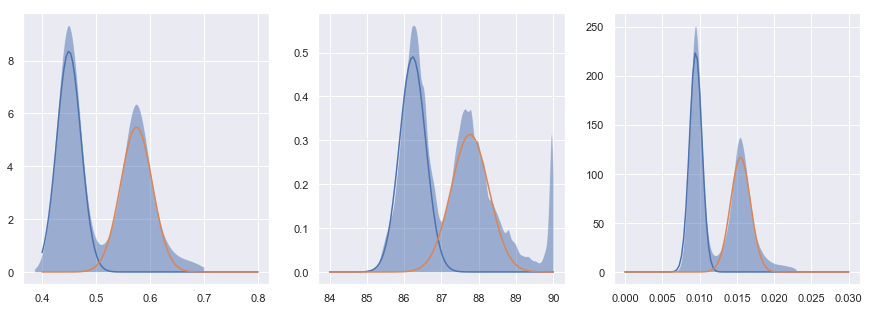

In [9]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
x1 = np.linspace(0.4,0.8,100)
y01 = double_gauss(x1,*popt1)
y11 = single_gauss(x1,popt1[0],popt1[1],popt1[2])
y12 = single_gauss(x1,popt1[3],popt1[4],popt1[5])

xd1,yd1 = oned_kde(data[1][index],1)

ax[0].fill_between(xd1, yd1, alpha=0.5)
ax[0].plot(x1,y11)
ax[0].plot(x1,y12)
#ax[0].axvline(x=popt1[1],color="crimson")
#ax[0].axvline(x=popt1[2]),color="blue")

x2 = np.linspace(84, 90, 100)
y02 = double_gauss(x2,*popt2)
y21 = single_gauss(x2,popt2[0],popt2[1],popt2[2])
y22 = single_gauss(x2,popt2[3],popt2[4],popt2[5])


xd2,yd2 = oned_kde(data[2][index],2)
ax[1].fill_between(xd2, yd2, alpha=0.5)
ax[1].plot(x2,y21)
ax[1].plot(x2,y22)

x3 = np.linspace(0.0, 0.03, 100)
y03 = double_gauss(x3,*popt3)
y31 = single_gauss(x3,popt3[0],popt3[1],popt3[2])
y32 = single_gauss(x3,popt3[3],popt3[4],popt3[5])

xd3,yd3 = oned_kde(data[4][index],4)
ax[2].fill_between(xd3, yd3, alpha=0.5)
ax[2].plot(x3,y31)
ax[2].plot(x3,y32)

plt.savefig("0822_multipeak_gaussians.png")

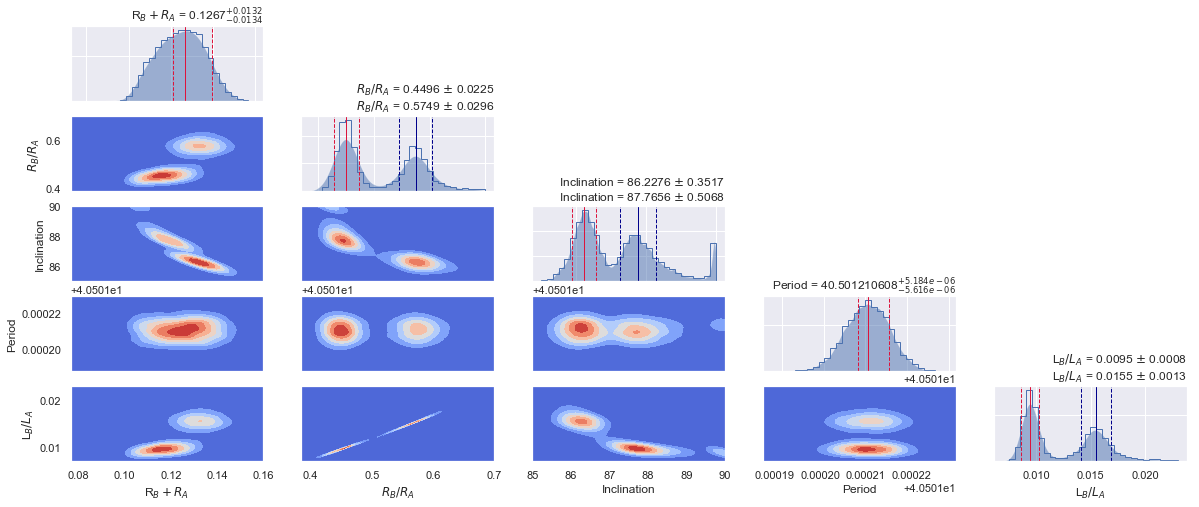

In [10]:
fig,ax = plt.subplots(nrows=5,ncols=5,figsize=(20,8))

for k in range(len(data)):

    x,y = oned_kde(data[k][index],k)


    for j in range(len(data)):
        if j > k:
            fig.delaxes(ax[k,j])
            continue
        else:
            ax[k,j].tick_params(labelbottom=False,labelleft=False)

        if k == j:
            ax[k,j].fill_between(x, y, alpha=0.5)
            ax[k,j].hist(data[k][index],histtype="step",bins=30,density=True)
            
            if k == 0:
                fifty     = np.percentile(data[k],50)
                onesigup  = np.percentile(data[k],84.14) - fifty
                onesigdwn = fifty - np.percentile(data[k],15.87)
                
                title = str(header[k]) + " = " + str(np.round(fifty,4))  \
                        + "$^{+" + str(np.round(onesigup,4)) + "}_{-"    \
                        + str(np.round(onesigdwn,4)) + "}$"
                ax[k,j].set_title(title,loc='right')
            
            if k == 1:
                title = str(header[k]) + " = " + str(np.round(popt1[1],4))  \
                        + " $\pm$ " + str(np.round(popt1[2],4)) + "\n" +    \
                        str(header[k]) + " = " + str(np.round(popt1[4],4))  \
                        + " $\pm$ " + str(np.round(popt1[5],4))
                ax[k,j].set_title(title,loc='right')

            if k == 2:
                title = str(header[k]) + " = " + str(np.round(popt2[1],4))  \
                        + " $\pm$ " + str(np.round(popt2[2],4)) + "\n" +    \
                        str(header[k]) + " = " + str(np.round(popt2[4],4))  \
                        + " $\pm$ " + str(np.round(popt2[5],4))
                ax[k,j].set_title(title,loc='right')

            if k == 3:
                fifty     = np.percentile(data[k],50)
                onesigup  = np.percentile(data[k],84.14) - fifty
                onesigdwn = fifty - np.percentile(data[k],15.87)
                
                title = str(header[k]) + " = " + str(np.round(fifty,10))  \
                        + "$^{+" + str(np.round(onesigup,10)) + "}_{-"    \
                        + str(np.round(onesigdwn,10)) + "}$"
                ax[k,j].set_title(title,loc='right')
       
            if k == 4:
                title = str(header[k]) + " = " + str(np.round(popt3[1],4))  \
                        + " $\pm$ " + str(np.round(popt3[2],4)) + "\n" +    \
                        str(header[k]) + " = " + str(np.round(popt3[4],4))  \
                        + " $\pm$ " + str(np.round(popt3[5],4))
                ax[k,j].set_title(title,loc='right')

            if k == 0 or k == 3:
                ax[k,j].axvline(x=np.percentile(data[k],50),color="crimson",linewidth=1)
                ax[k,j].axvline(x=np.percentile(data[k],34.135),color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=np.percentile(data[k],84.134),color="crimson",linestyle="--",linewidth=1)
            if k == 1:
                ax[k,j].axvline(x=popt1[1],color="crimson",linewidth=1)
                ax[k,j].axvline(x=popt1[1]+popt1[2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt1[1]-popt1[2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt1[4],color="darkblue",linewidth=1)
                ax[k,j].axvline(x=popt1[4]+popt1[5],color="darkblue",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt1[4]-popt1[5],color="darkblue",linestyle="--",linewidth=1)
            if k == 2:
                ax[k,j].axvline(x=popt2[1],color="crimson",linewidth=1)
                ax[k,j].axvline(x=popt2[1]+popt2[2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt2[1]-popt2[2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt2[4],color="darkblue",linewidth=1)
                ax[k,j].axvline(x=popt2[4]+popt2[5],color="darkblue",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt2[4]-popt2[5],color="darkblue",linestyle="--",linewidth=1)
         
            if k == 4:
                ax[k,j].axvline(x=popt3[1],color="crimson",linewidth=1)
                ax[k,j].axvline(x=popt3[1]+popt3[2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt3[1]-popt3[2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt3[4],color="darkblue",linewidth=1)
                ax[k,j].axvline(x=popt3[4]+popt3[5],color="darkblue",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt3[4]-popt3[5],color="darkblue",linestyle="--",linewidth=1)

        if k == len(data)-1:
            ax[k,j].tick_params(labelbottom=True)
            ax[k,j].set_xlabel(header[j])
        if j == 0:
            if k != 0:
                ax[k,j].tick_params(labelleft=True)
                ax[k,j].set_ylabel(header[k])

        if k != j:
            xx,yy,f = twod_kde(data[j][index],data[k][index])
            ax[k,j].contourf(xx,yy,f,cmap='coolwarm',origin='lower')
plt.savefig("0822_apo_jktebop.pdf")